In [1]:
!conda install -y gdown
!pip install google-play-scraper
!pip install PySastrawi

Retrieving notices: ...working... done
| / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ 

In [2]:
from google_play_scraper import Sort, reviews_all, reviews
import re
import pandas as pd
import numpy as np
import datetime as dt
import torch
import string
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, classification_report
# from google_play_scraper import Sort, reviews_all, reviews
import nltk
# import calendar
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('popular')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /usr/share/n

In [3]:
!nvidia-smi

Tue Feb 13 12:01:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              26W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
torch.cuda.is_available()

True

# Explore data dikit

In [5]:
data  = pd.read_csv("/kaggle/input/dirty-vote/dirtyvote.xls - dirtyvotes.csv")
data.head()

,Name,Comment,Time,Likes,Reply Count
0,@teguhhadyanto,Komentar komentar buzzeRp seragam,2/12/24 21:26,1,0.0
1,@ngkimwarkiman5388,Semoga indonesia jangan hanya tinggal nama,2/12/24 21:26,0,0.0
2,@hermawanbasri117,"Tidak sadarkah diri yg memangku amanah, bahwa ...",2/12/24 21:26,0,0.0
3,@winarnijhonwinarnijhon.2018,Sore ini aku mendapatkan amplop dan nama calon...,2/12/24 21:26,0,0.0
4,@rizkifauzan4579,02🎉,2/12/24 21:26,0,0.0


In [6]:
data.drop(axis = 1, columns= "Name", inplace=True) #for what we use name?
data.head(10)

,Comment,Time,Likes,Reply Count
0,Komentar komentar buzzeRp seragam,2/12/24 21:26,1,0.0
1,Semoga indonesia jangan hanya tinggal nama,2/12/24 21:26,0,0.0
2,"Tidak sadarkah diri yg memangku amanah, bahwa ...",2/12/24 21:26,0,0.0
3,Sore ini aku mendapatkan amplop dan nama calon...,2/12/24 21:26,0,0.0
4,02🎉,2/12/24 21:26,0,0.0
5,Semoga lebih dibukakan pemikiran yg masih mili...,2/12/24 21:26,0,0.0
6,segala angkara murka akan kalah oleh kebaikan\...,2/12/24 21:26,0,0.0
7,Tetap All in prabowo,2/12/24 21:26,0,0.0
8,Buka mata buka telinga dan buka hati. \nMari b...,2/12/24 21:26,0,0.0
9,BODO AMAT ALL IN PRABOWO,2/12/24 21:26,0,0.0


### Mari kita lihat koment dengan top like dan reply 

In [7]:
sort = data.sort_values(by="Likes", ascending=False)

In [8]:
sort.head()

,Comment,Time,Likes,Reply Count
61091,"Kids..kalo kelak kalian nonton film ini,yakinl...",2/11/24 20:00,29925,750.0
29582,"Ingat kata Iman Syafi'i ""Saat kamu menyampaika...",2/12/24 9:12,7395,591.0
62985,"Mari kita doakan agar para narasumber, tim pem...",2/11/24 19:07,7150,396.0
61464,Terimakasih telah berjuang untuk demokrasi neg...,2/11/24 19:52,6258,308.0
42731,"Tim produksi Dirty Vote, semoga kalian dilindu...",2/12/24 1:07,3790,271.0


Top komen di isi dengan komentar positif terkait dirty vote

# Data Preparation


data preparation akan terdiri dari:
1. Mengubah text comment menjadi lower case semua
2. Menghilangkan emoji
3. Menghilangkan kata-kata repetitif (kata diulangi lebih dari 2 kali)
4. Menghilangkan Hashtag
5. menghilangkan kata pendek (kurang dari 3 huruf)
6. Standarisasi kata slang
7. menghilangkan stop words
8. stemming 

In [9]:
def lowercase(review_text):
  low = review_text.lower()
  return low
data['clean_review'] = data['Comment'].apply(lambda low:lowercase(str(low)))

In [10]:
data.head()

,Comment,Time,Likes,Reply Count,clean_review
0,Komentar komentar buzzeRp seragam,2/12/24 21:26,1,0.0,komentar komentar buzzerp seragam
1,Semoga indonesia jangan hanya tinggal nama,2/12/24 21:26,0,0.0,semoga indonesia jangan hanya tinggal nama
2,"Tidak sadarkah diri yg memangku amanah, bahwa ...",2/12/24 21:26,0,0.0,"tidak sadarkah diri yg memangku amanah, bahwa ..."
3,Sore ini aku mendapatkan amplop dan nama calon...,2/12/24 21:26,0,0.0,sore ini aku mendapatkan amplop dan nama calon...
4,02🎉,2/12/24 21:26,0,0.0,02🎉


In [11]:
def remove_emoji(review_text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', review_text)

data['clean_review'] = data['clean_review'].apply(lambda emoji: remove_emoji(emoji))

In [12]:
def word_repetition(review_text):
  review = re.sub(r'(.)\1+', r'\1\1', review_text)
  return review

data['clean_review'] = data['clean_review'].apply(lambda word: word_repetition(word))
data.head()

,Comment,Time,Likes,Reply Count,clean_review
0,Komentar komentar buzzeRp seragam,2/12/24 21:26,1,0.0,komentar komentar buzzerp seragam
1,Semoga indonesia jangan hanya tinggal nama,2/12/24 21:26,0,0.0,semoga indonesia jangan hanya tinggal nama
2,"Tidak sadarkah diri yg memangku amanah, bahwa ...",2/12/24 21:26,0,0.0,"tidak sadarkah diri yg memangku amanah, bahwa ..."
3,Sore ini aku mendapatkan amplop dan nama calon...,2/12/24 21:26,0,0.0,sore ini aku mendapatkan amplop dan nama calon...
4,02🎉,2/12/24 21:26,0,0.0,02


In [13]:
def remove_hashtag(review_text, default_replace=""):
  hashtag = re.sub(r'#\w+', default_replace, review_text)
  return hashtag

data['clean_review'] = data['clean_review'].apply(lambda hashtag: remove_hashtag(hashtag))

data.head()

,Comment,Time,Likes,Reply Count,clean_review
0,Komentar komentar buzzeRp seragam,2/12/24 21:26,1,0.0,komentar komentar buzzerp seragam
1,Semoga indonesia jangan hanya tinggal nama,2/12/24 21:26,0,0.0,semoga indonesia jangan hanya tinggal nama
2,"Tidak sadarkah diri yg memangku amanah, bahwa ...",2/12/24 21:26,0,0.0,"tidak sadarkah diri yg memangku amanah, bahwa ..."
3,Sore ini aku mendapatkan amplop dan nama calon...,2/12/24 21:26,0,0.0,sore ini aku mendapatkan amplop dan nama calon...
4,02🎉,2/12/24 21:26,0,0.0,02


In [14]:
def remove_small_words(text):
  text = re.sub(r'\b\w{1,3}\b','',text)
  return text

data['clean_review'] = data['clean_review'].apply(lambda remove: remove_small_words(str(remove)))

In [15]:
slangs = open('/kaggle/input/slang-txt/slang.txt',"r",encoding="utf-8", errors='replace')
clear_slangs= []
for newlines in slangs:
  strip_re = newlines.strip("\n")
  split = re.split(r'[:]',strip_re)
  clear_slangs.append(split)

In [16]:
slangs = [[k.strip(), v.strip()] for k,v in clear_slangs]
dict_slangs = {key:values for key,values in slangs}

In [17]:
clean_text = []
for review in data['clean_review']:
  wordlist = TextBlob(review).words
  for k,v in enumerate(wordlist):
    if v in dict_slangs.keys():
      wordlist[k] = dict_slangs[v]
  clean_text.append(' '.join(wordlist))

data['clean_review'] = clean_text

In [18]:
data.head()

,Comment,Time,Likes,Reply Count,clean_review
0,Komentar komentar buzzeRp seragam,2/12/24 21:26,1,0.0,komentar komentar buzzerp seragam
1,Semoga indonesia jangan hanya tinggal nama,2/12/24 21:26,0,0.0,semoga indonesia jangan hanya tinggal nama
2,"Tidak sadarkah diri yg memangku amanah, bahwa ...",2/12/24 21:26,0,0.0,tidak sadarkah diri memangku amanah bahwa seti...
3,Sore ini aku mendapatkan amplop dan nama calon...,2/12/24 21:26,0,0.0,sore mendapatkan amplop nama calonnya apakah j...
4,02🎉,2/12/24 21:26,0,0.0,


In [19]:
def word_token(review_text):
  return word_tokenize(review_text)
data['token'] = data['clean_review'].apply(lambda tokenize:word_token(str(tokenize)))
data.head()

,Comment,Time,Likes,Reply Count,clean_review,token
0,Komentar komentar buzzeRp seragam,2/12/24 21:26,1,0.0,komentar komentar buzzerp seragam,"[komentar, komentar, buzzerp, seragam]"
1,Semoga indonesia jangan hanya tinggal nama,2/12/24 21:26,0,0.0,semoga indonesia jangan hanya tinggal nama,"[semoga, indonesia, jangan, hanya, tinggal, nama]"
2,"Tidak sadarkah diri yg memangku amanah, bahwa ...",2/12/24 21:26,0,0.0,tidak sadarkah diri memangku amanah bahwa seti...,"[tidak, sadarkah, diri, memangku, amanah, bahw..."
3,Sore ini aku mendapatkan amplop dan nama calon...,2/12/24 21:26,0,0.0,sore mendapatkan amplop nama calonnya apakah j...,"[sore, mendapatkan, amplop, nama, calonnya, ap..."
4,02🎉,2/12/24 21:26,0,0.0,,[]


In [20]:
review_all = []

for review in data['clean_review']:
  text = review.split()
  for token_review in text:
    review_all.append(token_review)

freq_dist = FreqDist(review_all)
print("how many frequency distribution samples from an entire dirty vote commnet")
freq_dist

how many frequency distribution samples from an entire dirty vote commnet


FreqDist({'yang': 18991, 'film': 11026, 'tidak': 10978, 'untuk': 8898, 'sudah': 7978, 'saya': 7958, 'kita': 7758, 'dari': 7505, 'indonesia': 7156, 'semua': 6449, ...})

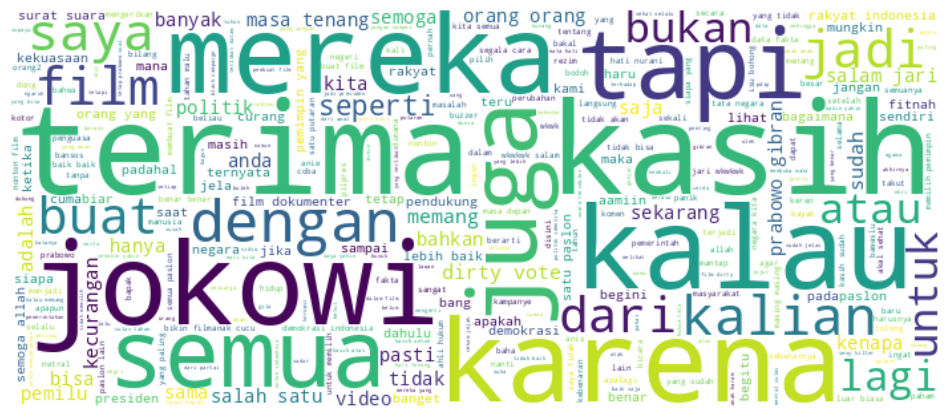

In [21]:
join_review = ' '.join(review_all)

w_cloud = WordCloud(background_color="white",
                    width=700, height=300, max_font_size=120,
                    max_words=500, contour_color='blue',
                    contour_width=2).generate(str(join_review))

# plot wordcloud
plt.figure(figsize=(12,12))
plt.imshow(w_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [22]:
# menampilkan kata stopwords bahasa indonesia
indonesian_stop = stopwords.words('indonesian')

# menghitung jumlah kata stopwords bahasa indonesia
print('length of indonesian stopwords:', len(indonesian_stop))

length of indonesian stopwords: 758


In [23]:
stopwords_indo = pd.DataFrame(indonesian_stop, columns=['stopwords_indonenesia'])
stopwords_indo.head()


,stopwords_indonenesia
0,ada
1,adalah
2,adanya
3,adapun
4,agak


In [24]:
def remove_stopwords(review_text, indo_stopwords):
  tokenize = []
  for token in review_text:
    if token not in indo_stopwords:
      tokenize.append(token)
  
  return tokenize

data['stop_review'] = data['token'].apply(lambda stop: remove_stopwords(stop, indonesian_stop))
data.head()

,Comment,Time,Likes,Reply Count,clean_review,token,stop_review
0,Komentar komentar buzzeRp seragam,2/12/24 21:26,1,0.0,komentar komentar buzzerp seragam,"[komentar, komentar, buzzerp, seragam]","[komentar, komentar, buzzerp, seragam]"
1,Semoga indonesia jangan hanya tinggal nama,2/12/24 21:26,0,0.0,semoga indonesia jangan hanya tinggal nama,"[semoga, indonesia, jangan, hanya, tinggal, nama]","[semoga, indonesia, tinggal, nama]"
2,"Tidak sadarkah diri yg memangku amanah, bahwa ...",2/12/24 21:26,0,0.0,tidak sadarkah diri memangku amanah bahwa seti...,"[tidak, sadarkah, diri, memangku, amanah, bahw...","[sadarkah, memangku, amanah, langkah, gerak, g..."
3,Sore ini aku mendapatkan amplop dan nama calon...,2/12/24 21:26,0,0.0,sore mendapatkan amplop nama calonnya apakah j...,"[sore, mendapatkan, amplop, nama, calonnya, ap...","[sore, amplop, nama, calonnya, lakukan]"
4,02🎉,2/12/24 21:26,0,0.0,,[],[]


In [25]:
def back_to_root(review_text):
  stop_token = ' '.join(review_text)
  stem = StemmerFactory()
  create_stem = stem.create_stemmer()
  result_stem = create_stem.stem(stop_token)
  return result_stem

data['stem_review'] = data['stop_review'].apply(lambda stem:back_to_root(stem))

In [26]:
review_all = []

for review in data['stem_review']:
  text = review.split()
  for token_review in text:
    review_all.append(token_review)

freq_dist = FreqDist(review_all)
print("how many frequency distribution samples from an entire dirty vote commnet (after stemming and stop words)")
freq_dist

how many frequency distribution samples from an entire dirty vote commnet (after stemming and stop words)


FreqDist({'film': 11577, 'pilih': 9023, 'indonesia': 7389, 'orang': 6852, 'rakyat': 6188, 'paslon': 5389, 'negara': 5154, 'jokowi': 5089, 'moga': 5037, 'curang': 4373, ...})

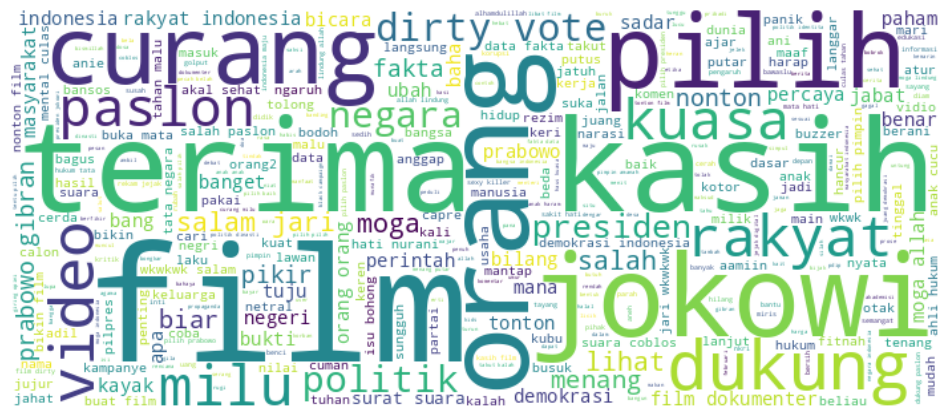

In [27]:
join_review = ' '.join(review_all)

w_cloud = WordCloud(background_color="white",
                    width=700, height=300, max_font_size=120,
                    max_words=500, contour_color='blue',
                    contour_width=2).generate(str(join_review))

# plot wordcloud
plt.figure(figsize=(12,12))
plt.imshow(w_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Data Labelling and EDA

model yang digunakan untuk labelling adalah bert-base-indonesian

In [28]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
label = ['positif', 'netral', 'negatif']
# Load pre-trained model and tokenizer
model_name = "ayameRushia/bert-base-indonesian-1.5G-sentiment-analysis-smsa"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Example input text
input_text = "aku cinta indonesia"

# Tokenize input text
input_ids = tokenizer.encode(input_text, add_special_tokens=True, max_length=1024, truncation=True, return_tensors='pt').to(device)

# Perform inference
with torch.no_grad():
    outputs = model(input_ids)
    logits = outputs.logits

# Get predicted label
predicted_label = torch.argmax(logits, dim=1).item()
print("Predicted label:",label[predicted_label])


tokenizer_config.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/230k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/476k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/899 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Predicted label: positif


In [29]:
output=[]
for i, val in data.iterrows():
    input_ids = tokenizer.encode(val['clean_review'], add_special_tokens=True,  max_length=512, truncation=True,  return_tensors='pt').to(device)
    with torch.no_grad():
        try:
            outputs = model(input_ids)
        except:
            print(val['clean_review'])
            break
        logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()
    output.append(label[predicted_label])

In [30]:
data['label'] = output
data.head()

,Comment,Time,Likes,Reply Count,clean_review,token,stop_review,stem_review,label
0,Komentar komentar buzzeRp seragam,2/12/24 21:26,1,0.0,komentar komentar buzzerp seragam,"[komentar, komentar, buzzerp, seragam]","[komentar, komentar, buzzerp, seragam]",komentar komentar buzzerp seragam,netral
1,Semoga indonesia jangan hanya tinggal nama,2/12/24 21:26,0,0.0,semoga indonesia jangan hanya tinggal nama,"[semoga, indonesia, jangan, hanya, tinggal, nama]","[semoga, indonesia, tinggal, nama]",moga indonesia tinggal nama,negatif
2,"Tidak sadarkah diri yg memangku amanah, bahwa ...",2/12/24 21:26,0,0.0,tidak sadarkah diri memangku amanah bahwa seti...,"[tidak, sadarkah, diri, memangku, amanah, bahw...","[sadarkah, memangku, amanah, langkah, gerak, g...",sadar memang amanah langkah gerak gerik pertan...,negatif
3,Sore ini aku mendapatkan amplop dan nama calon...,2/12/24 21:26,0,0.0,sore mendapatkan amplop nama calonnya apakah j...,"[sore, mendapatkan, amplop, nama, calonnya, ap...","[sore, amplop, nama, calonnya, lakukan]",sore amplop nama calon laku,netral
4,02🎉,2/12/24 21:26,0,0.0,,[],[],,positif


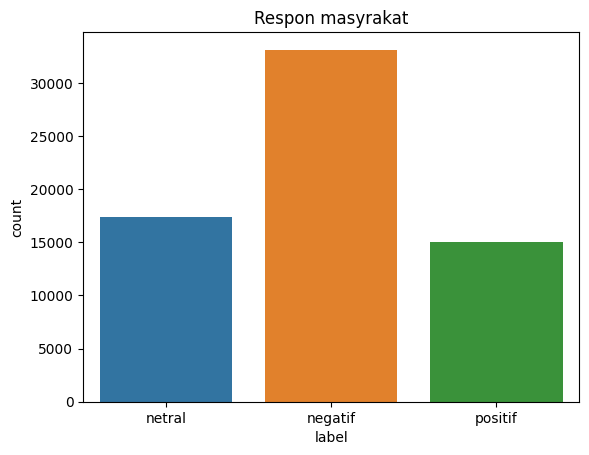

In [31]:
import seaborn as sns

sns.countplot(data, x='label')
plt.title("Respon masyrakat")
plt.show()

Mari kita lihat tanggapan komentar top 50 berdasarkan like

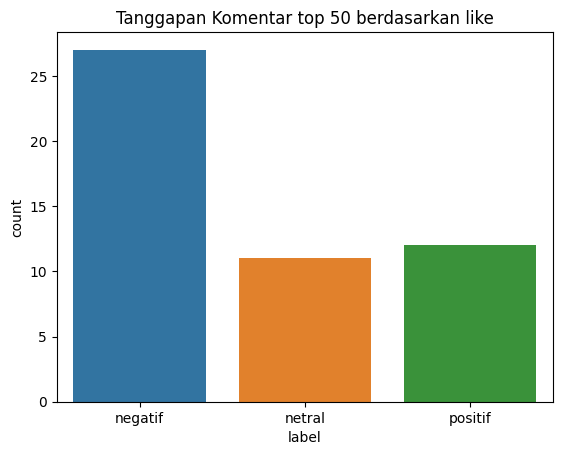

In [32]:
sns.countplot(data[:50].sort_values('Likes', ascending=False), x='label')
plt.title("Tanggapan Komentar top 50 berdasarkan like")
plt.show()

Perlu dikeatui bahwa tanggapan negatif dan positif bukan hanya menanggapi film dirty vote namun juga isi dari apa yang disampaikan dalam dirty vote entah itu mengenai pemerintahan ataupun paslon tertentu. maka dari itu akan saya coba pisah tiap komentar berdasarkan paslon yang dibahas menggunakan beberapa kata kunci

In [33]:
def calculate(keyword: list):
    paslon = []
    for i, val in data.iterrows():
        for word in keyword:
            if word in val['clean_review'].split():
                paslon.append(i)
                break
    return data.iloc[paslon]
    

In [34]:
paslon2 = calculate(['02', 'prabowo', 'gibran'])
paslon2['Comment'].head()

7                                  Tetap All in prabowo
9                              BODO AMAT ALL IN PRABOWO
27    Gak Akannnnn Lupa Pilpres 2019..... bisa bisa ...
42    Setelah menonton film ini, saya sekeluarga bes...
50    biasa kalo mau ada yg 5th nan nyalon ada aja f...
Name: Comment, dtype: object

In [35]:
paslon1 = calculate(['01', 'anies', 'anis', 'muhaimin', 'imin'])
paslon1['Comment'].head()

65     Film ini sangat mendidiik untuk calon yg blm m...
93     Wow yg katanya pak anies pintar berkata kata, ...
103    kenapa filmnya meluncur saat masa tenang kampa...
116                        pos Pengumben dukung Anies...
122    Astagfirullahal"Azim 10,000  X  !!!  Yaa Allah...
Name: Comment, dtype: object

In [36]:
paslon3 = calculate(['03', 'ganjar', 'mahfud', 'mahpud'])
paslon3['Comment'].head()

15    Sebener nya disini yg paling dirugikan tuh pak...
33    Pak ganjar adakah korban dari rusaknya konstitusi
42    Setelah menonton film ini, saya sekeluarga bes...
69     Korbannya termasuk pak ganjar dan pak mahfud sih
84       Makin yakin yg bakalan menang pasti pak ganjar
Name: Comment, dtype: object

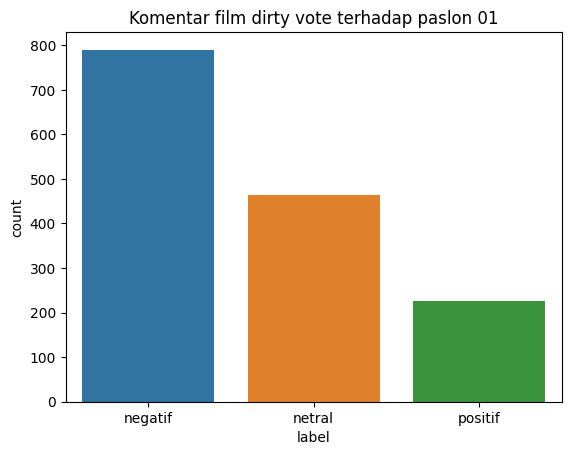

In [37]:
sns.countplot(paslon1, x='label')
plt.title('Komentar film dirty vote terhadap paslon 01')
plt.show()

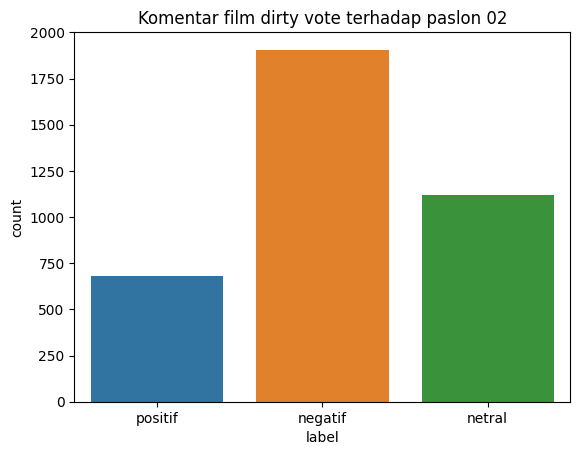

In [38]:
sns.countplot(paslon2, x='label')
plt.title('Komentar film dirty vote terhadap paslon 02')
plt.show()

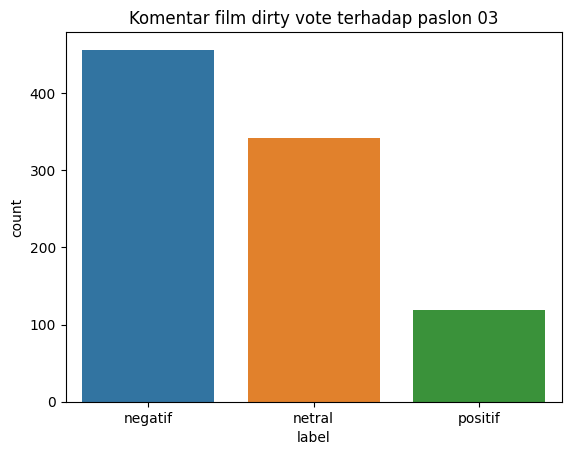

In [39]:
sns.countplot(paslon3, x='label')
plt.title('Komentar film dirty vote terhadap paslon 03')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


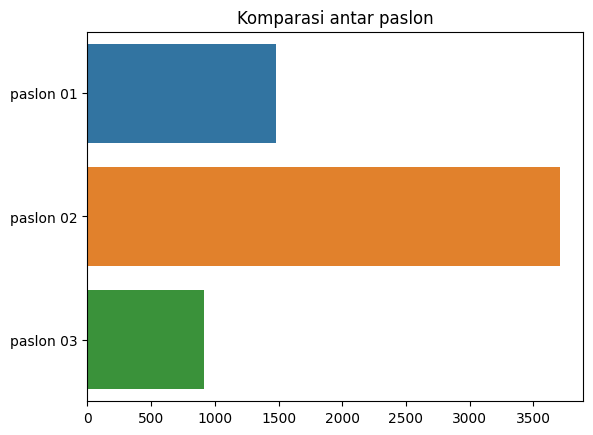

In [40]:
sns.barplot(x=[len(paslon1), len(paslon2), len(paslon3)], y=['paslon 01', 'paslon 02', 'paslon 03'])
plt.title('Komparasi antar paslon')
plt.show()

Bisa dilihat bahwa paslon 02 paling sering disinggung, diikuti paslon 01 dan paslon 03

# Kesimpulan

Dari data di atas dapat disimpulkan bahwa paslon 02 paling banyak disinggung mengingat konten dirty vote menyampaikan banyak kritik tentang paslon 02. Hal tersebut juga tak luput dari presiden sendiri yaitu "jokowi" sebagai kata yang paling banyak disinggung bila dibandingkan dengan paslon lainnya, mengingat data yang kita dapat label negatif merupakan label terbanyak maka ini menampakkan ketidakpuasan masyrakat terhadap presiden. Hal ini juga berlaku pada paslon lainnya, tiap paslon memiliki label negatif lebih banyak dibandingkan dengan label lainnya. Secara keseluruhan banyak dari masyrakat yang berkomentar pada film dirty tidak puas dengan kebijakan pemerintahan serta paslon yang mencalonkan diri sebagai capres dan cawapres